<a href="https://colab.research.google.com/github/nklsKrmnn/LSC_Sentiment_Analysis/blob/main/Projekt_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/LSC_Sentiment_Analysis'

/content/drive/MyDrive/LSC_Sentiment_Analysis


In [ ]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [ ]:
!jt -r

Reset css and font defaults in:
C:\Users\nikla\.jupyter\custom &
C:\Users\nikla\AppData\Roaming\jupyter\nbextensions


# 0. Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")


# 1. Dataset: Movie Reviews

In [4]:
dataset_mr = pd.read_csv("./data/train.tsv", sep='\t')

In [5]:
dataset_mr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [6]:
dataset_mr.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [8]:
pd.set_option('display.max_colwidth', None)
dataset_mr.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what is good for the goose,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is good for the goose,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for the goose,2


<Axes: xlabel='Sentiment', ylabel='count'>

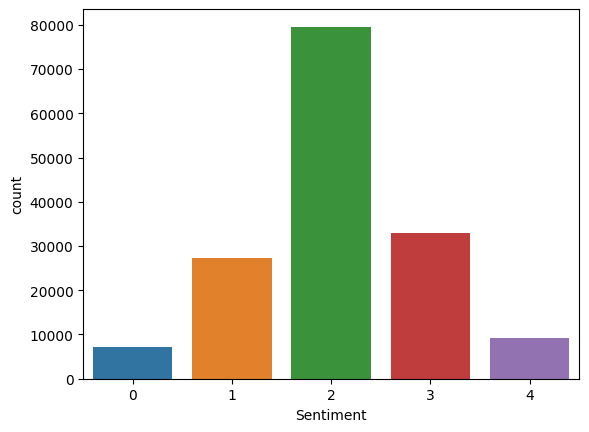

In [9]:
sns.countplot(x='Sentiment', data=dataset_mr)
# TODO: Beschriftungen & Schlussfolgerung

In [10]:
dataset_mr_full_senences = dataset_mr.groupby('SentenceId').first().reset_index()
dataset_mr_full_senences.head(5)

,SentenceId,PhraseId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,64,"This quiet , introspective and entertaining independent is worth seeking .",4
2,3,82,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",1
3,4,117,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .",3
4,5,157,Aggressive self-glorification and a manipulative whitewash .,1


<Axes: xlabel='Sentiment', ylabel='count'>

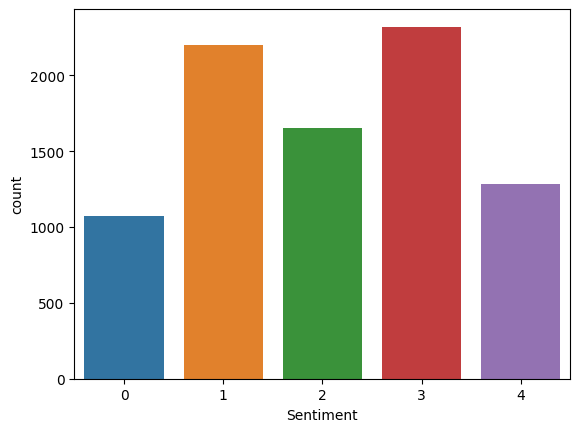

In [11]:
sns.countplot(x='Sentiment', data=dataset_mr_full_senences)
# --> besser

In [12]:
value_mapping = {0: -1, 1: -1, 2: 0, 3: 1, 4: 1}
dataset_mr_relabled = dataset_mr_full_senences
dataset_mr_relabled['Sentiment'] = dataset_mr_relabled['Sentiment'].map(value_mapping)
dataset_mr_relabled.head()

,SentenceId,PhraseId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",-1
1,2,64,"This quiet , introspective and entertaining independent is worth seeking .",1
2,3,82,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",-1
3,4,117,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .",1
4,5,157,Aggressive self-glorification and a manipulative whitewash .,-1


In [13]:
def dataset_split(dataset: pd.DataFrame, n: int):
    """
    Funktion, um ein dataset in mehrere gleichgroße Datasets zu splitte
    :param dataset: dataset, das gesplittet werden soll
    :param n: Anzahl der Subset, in die gesplittet werden soll
    :return: Subsets
    """
    set_size = dataset.shape[0]/n
    subsets = []
    for _ in range(n):
        subsets.append(dataset.loc[_*set_size:(_+1)*set_size, :])
    return subsets


In [14]:
def balancing(dataset: pd.DataFrame, column_label: str):
    """
    Funktion um einen Datensatz nach enthaltenen Labels zu balancen.
    :param dataset: Dataset, das balanced werden soll.
    :param column_label: Spalte in der sich die Labels befinden.
    :return: Balanced dataset
    """
    balanced_set = dataset
    sentiment_groups = dataset[column_label].value_counts()
    max_size = sentiment_groups.max()

    for i in sentiment_groups.index.values:
        ratio = int(max_size / sentiment_groups[i])

        for j in range(int(ratio)+1):
            current_size = balanced_set[column_label].value_counts()[i]
            n = min([(max_size-current_size), sentiment_groups[i]])
            balanced_set = pd.concat([balanced_set, dataset.loc[dataset[column_label] == i].sample(n=n)])

    return balanced_set.sample(frac=1)

In [15]:
def save_dataset(dataset, name, path):
    """
    Speichert ein pandas DataFrame als csv
    :param dataset: pandas DataFrame
    :param name: Name des csv-files
    :param path: Pfand zum Ordner, wo das csv-file gespeichert werden soll
    :return: None
    """
    file_path = path + "/"+ name
    dataset.to_csv(path_or_buf=file_path, sep=";")

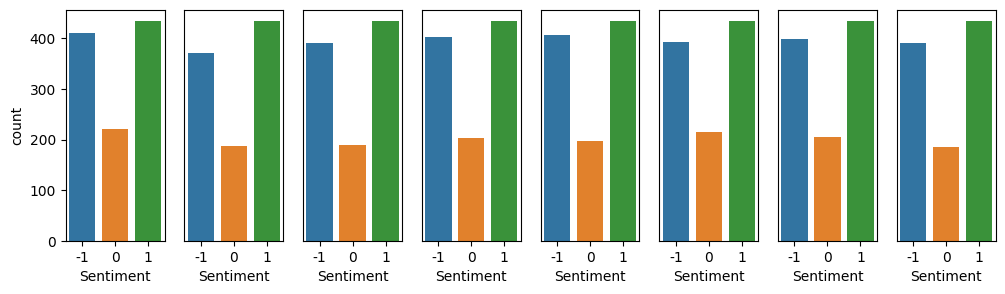

In [16]:
subsets = dataset_split(dataset_mr_relabled, 8)

fig, axes = plt.subplots(1, len(subsets), figsize=(12,3))
for _, ax in enumerate(axes):
    sns.countplot(x='Sentiment', data=subsets[_], ax=ax)
    if (_ > 0):
        ax.get_yaxis().set_visible(False)

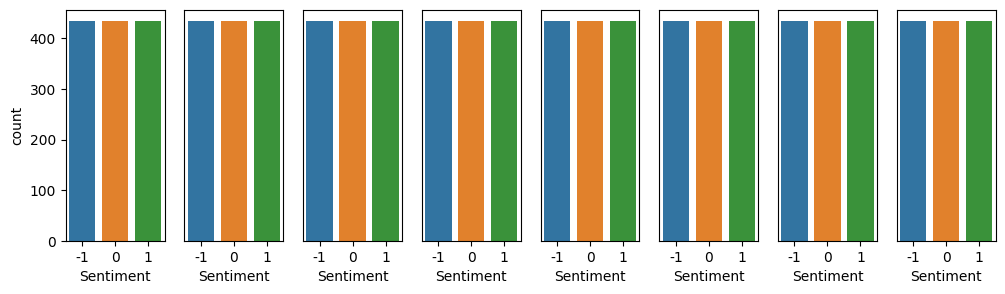

In [17]:
for i in range(len(subsets)):
    subsets[i] = balancing(subsets[i], "Sentiment")

fig, axes = plt.subplots(1, len(subsets), figsize=(12,3))
for _, ax in enumerate(axes):
    sns.countplot(x='Sentiment', data=subsets[_], ax=ax)
    if (_ > 0):
        ax.get_yaxis().set_visible(False)

In [ ]:
# Zusammenfügen gesamttrainingsset
trainset_complete = pd.concat(subsets[:6])

dir_path = "../data/datasets_mr"

save_dataset(subsets[0], "Trainset_1.csv", dir_path)
save_dataset(subsets[1], "Trainset_2.csv", dir_path)
save_dataset(subsets[2], "Trainset_3.csv", dir_path)
save_dataset(subsets[3], "Trainset_4.csv", dir_path)
save_dataset(subsets[4], "Trainset_5.csv", dir_path)
save_dataset(subsets[5], "Trainset_6.csv", dir_path)
save_dataset(trainset_complete, "Trainset_complete.csv", dir_path)
save_dataset(subsets[6], "Evaluationset.csv", dir_path)
save_dataset(subsets[7], "Testset.csv", dir_path)

OSError: ignored

In [ ]:
# TODO: (Niklas): Amazon dataset https://www.kaggle.com/datasets/751487ccef508fca5ede15ba1cf2b7e44edbc763fb91cb5d26fd6c28ddd87d91

In [ ]:
# TODO: (Eira): Tweets dataset https://www.kaggle.com/datasets/kazanova/sentiment140